# Try models

In [234]:
import glob
import re
import pickle

import numpy as np
import pandas as pd
from isoweek import Week
from pandas_summary import DataFrameSummary
import itertools
import utils
import lightgbm as lgb
import random
import matplotlib.pyplot as plt, xgboost, operator, random, pickle
# from keras.models import model_from_yaml
from pandas_summary import DataFrameSummary
from importlib import reload
reload(utils)
import matplotlib

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)

import math
def rmsle(y_pred, targ):
    log_vars = np.log(targ + 1) - np.log(y_pred + 1)
    return math.sqrt(np.square(log_vars).mean())
def plot_impt(model):
    importance = model.get_fscore()
    importance = sorted(importance.items(), key=operator.itemgetter(1))

    df = pd.DataFrame(importance, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()

    df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance');
    # df[df.fscore < 0.009].feature.tolist()

def rmsle_wo_log(y_predicted, y_true):
    y_true = y_true.get_label()
    y_predicted_orig = utils.log_max_inv(y_predicted, max_log_y)
    y_true_orig = utils.log_max_inv(y_true, max_log_y)
    score = rmsle(y_predicted_orig, y_true_orig)
    return ('rmsle', score, False)

def rmsle_wo_log_sk(y_predicted, y_true):
    y_predicted_orig = utils.log_max_inv(y_predicted, max_log_y)
    y_true_orig = utils.log_max_inv(y_true, max_log_y)
    score = rmsle(y_predicted_orig, y_true_orig)
    return score
drop_vars = ['visit_date_month',
 'hpb_loc',
 'hpb_genre_name',
 'air_loc',
 'genre_name',
 'visit_date_week',
 'area_name',
 'air_store_id',
 'visit_date_dayofweek',
 'prop_yhat_lower',
 'prop_seasonal_upper',
 'max_visits_in_air_store_id',
 'af_holiday_flg',
 'prop_3_lower',
 'prop_3_upper',
 'prop_holidays_lower',
 'prop_seasonal_lower',
 'prop_weekly_upper',
 'prop_1',
 'prop_holidays_upper',
 'prop_2_lower',
 'min_visits_in_air_store_id',
 'prop_2_upper',
 'stores_in_area_name',
 'prop_trend_lower',
 'prop_3',
 'max_visits_in_area_name',
 'prop_6',
 'rolling_60d_median',
 'prop_yhat_upper',
 'prop_1_upper',
 'std_visits_in_air_store_id',
 'prop_6_lower',
 'prop_seasonalities_upper',
 'rolling_60d_std',
 'mean_visits_in_air_loc',
 'be_holiday_flg',
 'std_visits_in_air_loc',
 'prop_6_upper',
 'visit_date_ts',
 'prop_weekly_lower',
 'prop_trend',
 'prop_yhat',
 'rolling_60d_min',
 'prop_weekly',
 'prop_2',
 'prop_seasonal',
 'prop_seasonalities_lower',
 'prop_seasonalities',
 'rolling_60d_max',
 'prop_1_lower',
 'prop_trend_upper',
 'prop_holidays',
 'mean_visits_in_air_store_id',
             'visit_date', 
             'visitors', 
             'hpb_area_name', 'stores_in_air_loc',
       'stores_in_hpb_loc', 'stores_in_hpb_area_name', 'Date', 'holiday_flg',
       'dur_time_holiday_flg', 'dur_holiday_flg', 'dur_prog_holiday_flg',
       'prop_yhat', 
             'min_visits_in_air_loc', 'max_visits_in_air_loc',
       'min_visits_in_hpb_loc', 'max_visits_in_hpb_loc',
       'mean_visits_in_hpb_loc', 'std_visits_in_hpb_loc',
       'min_visits_in_area_name', 
             'mean_visits_in_area_name',
       'std_visits_in_area_name', 'min_visits_in_hpb_area_name',
       'max_visits_in_hpb_area_name', 'mean_visits_in_hpb_area_name',
       'std_visits_in_hpb_area_name', 'visit_date_year']

In [235]:
data_dir = r'./data'
trn = pd.read_csv('{}/air_visit_data.csv'.format(data_dir))

keep_vars = [
    'prop_yhat_lower',
    'prop_yhat',
    'prop_yhat_upper',
    'visitors', 
    'area_name',
    'air_store_id',
]

cat_vars = [] # "air_store_id"
contin_vars = [] # 
precup_vars = ["prop_yhat", "prop_yhat_lower", "prop_yhat_upper"]
all_vars = cat_vars + conti_vars + ["visitors"]

drop_vars = list(set(drop_vars) - set(keep_vars))
feas = utils.data2fea(trn, data_dir, drop_vars=drop_vars)

In [236]:
input_map = feas['sk_fea']
y = feas['y']
tidy_data = feas['tidy_data']
all_vars = feas['all_vars']
cat_vars = feas['cat_vars']

In [238]:
contin_vars

[]

In [239]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, LabelBinarizer, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline

data_set = tidy_data[keep_vars]


def uniform(y_orig):
    max_log_y = np.max(np.log1p(y_orig))
    return np.log1p(y_orig) / max_log_y

def mat2fea(mat, cat_vars, contin_vars, precup_vars):
    " from feature dataframe to matrix based on type"
    mat[contin_vars] = mat[contin_vars].astype('float')
    for v in contin_vars:
        mat.loc[mat[v].isnull(), v] = 0
    for v in precup_vars:
        mat.loc[mat[v].isnull(), v] = 0
    for v in cat_vars:
        mat.loc[mat[v].isnull(), v] = ""
    
    if cat_vars:
        cat_maps = [(o, LabelEncoder()) for o in cat_vars]
        cat_mapper = DataFrameMapper(cat_maps)
        cat_map_fit = cat_mapper.fit(mat)
        cat_map = cat_map_fit.transform(mat).astype(np.int64)

        mat[cat_vars] = cat_map
        onehot_mapper = DataFrameMapper([
            (['air_store_id'], OneHotEncoder())
        ])
        onehot_fit = onehot_mapper.fit(mat)
        cat_map = onehot_fit.transform(mat)
    if contin_vars:
        contin_maps = [([o], StandardScaler()) for o in contin_vars]
        contin_mapper = DataFrameMapper(contin_maps)
        contin_map_fit = contin_mapper.fit(mat)
        contin_map = contin_map_fit.transform(mat).astype(np.float)
    # cat_map, 
    if precup_vars:
        precup_map = mat[precup_vars].apply(uniform).fillna(0).values
    return_vars = []
    if cat_vars: return_vars.append(cat_map)
    if contin_vars: return_vars.append(contin_map)
    if precup_vars: return_vars.append(precup_map)
    return np.concatenate(return_vars, axis=1), mat.visitors.values

X, Y = mat2fea(data_set, cat_vars, contin_vars, precup_vars)

# X, Y = data_set.prop_yhat.values, data_set.visitors
Y = Y[:].reshape(-1,1)

/usr/local/lib64/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log1p
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log1p
  # Remove the CWD from sys.path while we 

In [240]:
X

array([[ 0.        ,  0.        ,  0.        , ...,  0.45517783,
         0.59395625,  0.69226266],
       [ 0.        ,  0.        ,  0.        , ...,  0.70487784,
         0.8496031 ,  0.82921144],
       [ 0.        ,  0.        ,  0.        , ...,  0.76019329,
         0.86967497,  0.86887366],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.63264898,
         0.80188847,  0.78068175],
       [ 0.        ,  0.        ,  0.        , ...,  0.47622345,
         0.56962899,  0.7412049 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.31980572,
         0.40204384,  0.57967377]])

In [241]:
date_sr = pd.to_datetime(tidy_data.Date)
# data_range = [12]
# ntree_range = [32]
evals_result = {}

# for try_items in itertools.product(data_range, ntree_range):
data_i = 0
dat = utils.data_split_by_date(
    X, Y, date_sr, trn2val_ratio=9, step_days=500)
# valid & trn splitting
dat_d = dat[data_i]
X_train, y_train_orig, X_valid, y_valid_orig = dat_d['x_trn'], dat_d['y_trn'], dat_d['x_valid'], dat_d['y_valid']
y_train, y_valid, max_log_y = utils.uniform_y(y_train_orig, y_valid_orig)

In [242]:
from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [244]:
pred_valid = reg.predict(X_valid)
pred_valid_orig = utils.log_max_inv(pred_valid, max_log_y)
# pred_valid_orig = pred_valid
valid_loss = rmsle(pred_valid_orig, y_valid_orig)
pred_trn = reg.predict(X_train)
pred_trn_orig = utils.log_max_inv(pred_trn, max_log_y)
# pred_trn_orig = pred_trn
trn_loss = rmsle(pred_trn_orig, y_train_orig)
print('data set: {}/{} train loss: {}, valid loss: {}'.format(data_i+1, len(dat), trn_loss, valid_loss))

data set: 1/1 train loss: 0.48914796885552275, valid loss: 0.4930469515540667


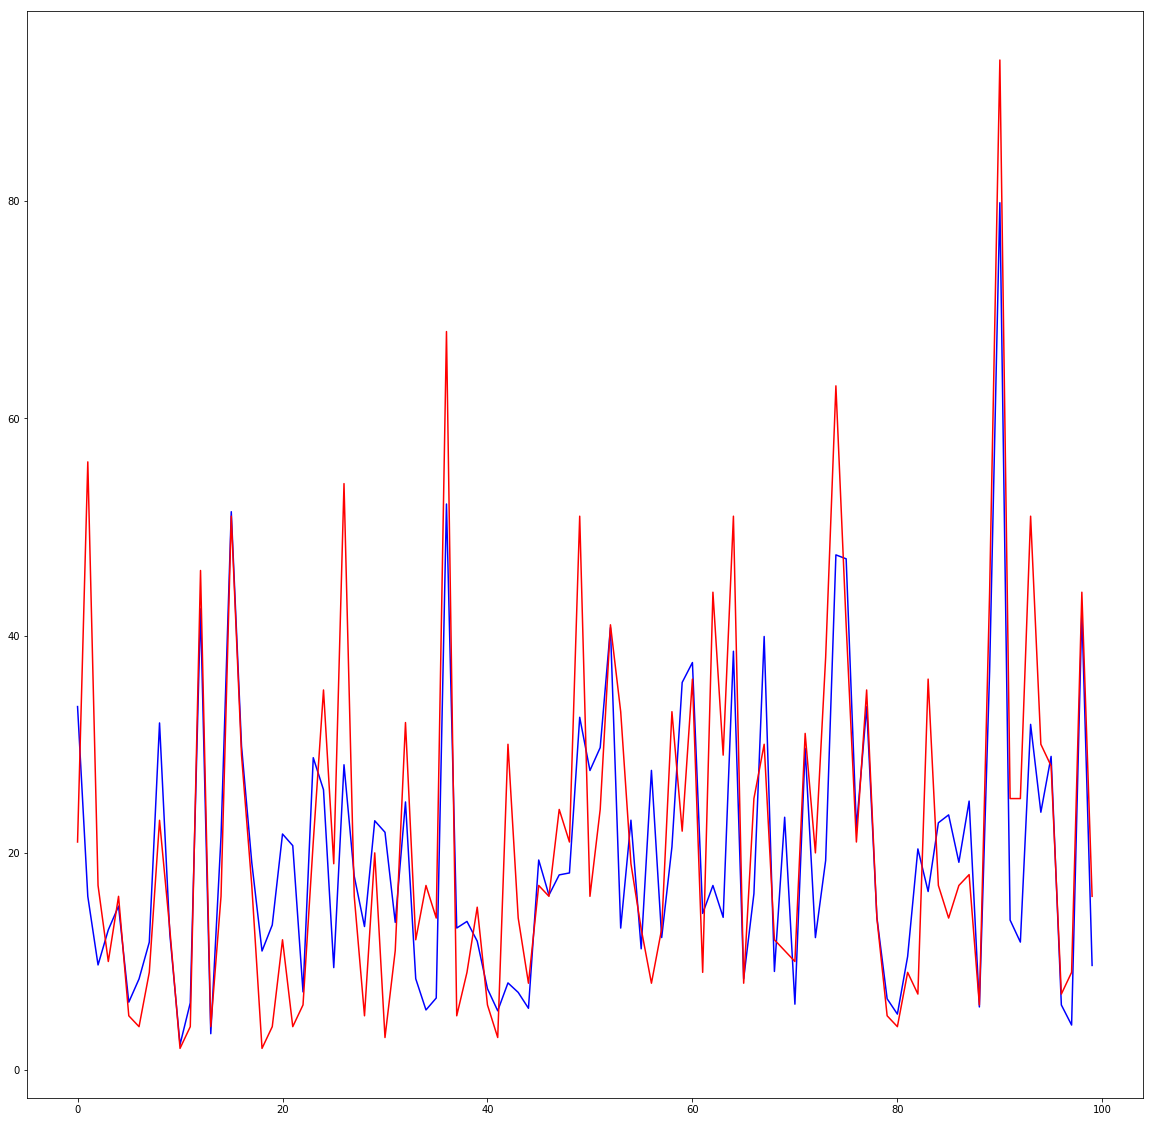

In [245]:
plt.plot(pred_valid_orig[:100], c='b')
plt.plot(y_valid_orig[:100], c='r')